In [1]:
# # # #Uncomment this in case you're missing some of them
# !pip3 install Box2D
# !pip3 install box2d-py
# !pip3 install gym[all]
# !pip3 install gym[Box_2D]
# # #neccecary installations
# # #add sudo to  command below in local machine

In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder 
from IPython.display import HTML
from IPython import display 
import glob
import collections
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape) 
print('Number of actions: ', env.action_space.n) 
class DeepQN(nn.Module):
    def __init__(self, inputShape, nActions,device="cpu"):
        super(DeepQN, self).__init__()

        self.fc1 = nn.Linear(inputShape[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, nActions)
        self.device=device
    def forward(self, x):
          x=x.to(self.device)
          x = self.fc1(x)
          x = F.relu(x)
          x = self.fc2(x)
          x = F.relu(x)
          x = self.fc3(x)
          x = F.relu(x)
          return self.fc4(x)

env = gym.make('LunarLander-v2')
conf = {
    'gamma':  0.99,
    'batchSize': 64,
    'replaySize':  int(1e5),
    'learningRate':  7e-4,
    'syncTargetFrames':  100,
    'replayStartSize':  100,
    'epsilonStart':  1.0,
    'epsEnd':  0.01,
    'epsDecayRate':  0.997
}

Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'newState'])

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self): return len(self.buffer)

    def append(self, experience): self.buffer.append(experience)

    def sample(self):
        states, actions, rewards, dones, nextStates = zip(*[self.buffer[idx] for idx in np.random.choice(len(self.buffer), conf['batchSize'], replace=False)])
        states = torch.tensor(np.array(states, copy=False)).to(device)
        nextStates = torch.tensor(np.array(nextStates, copy=False)).to(device)
        actions = torch.tensor(np.array(actions)).to(device)
        rewards = torch.tensor(np.array(rewards, dtype=np.float32)).to(device)
        dones   = torch.BoolTensor(np.array(dones, dtype=np.uint8)).to(device)
        return states, actions, rewards, dones, nextStates
        
class Agent_Double_DQN:
    def __init__(self, env, expBuffer):
        self.env = env
        self.expBuffer = expBuffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.totalReward = 0.0

    @torch.no_grad()
    def playStep(self, net, epsilon=0.0, device="cuda"):
        doneReward = None

        action = env.action_space.sample() if np.random.random() < epsilon else \
                 int(torch.max(net(torch.tensor(np.array([self.state], copy=False)).to(device)), dim=1)[1].item())

        # do step in the environment
        newState, reward, finished, _ = self.env.step(action)
        self.totalReward += reward

        self.expBuffer.append(Experience(self.state, action, reward, finished, newState))
        self.state = newState
        if finished:
            doneReward = self.totalReward
            self._reset()
        return doneReward

def loss(batch, net, tgtNet, device="cpu"):
    states, actions, rewards, doneMask, nextStates = batch
    
    stateActionValues = net(states).gather(1, actions[:, None]).flatten()

    with torch.no_grad():
        nextStateActs = net(nextStates).max(1)[1]
        nextStateActs = nextStateActs[:,None]
        nextStateValues = tgtNet(nextStates).gather(1, nextStateActs).flatten()
        nextStateValues[doneMask] = .0
        nextStateValues = nextStateValues.detach()


    return nn.MSELoss()(stateActionValues, nextStateValues * conf['gamma'] + rewards)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DeepQN(env.observation_space.shape, env.action_space.n,device=device).to(device)
tgtNet = DeepQN(env.observation_space.shape, env.action_space.n,device=device).to(device)


buffer = ExperienceBuffer(conf['replaySize'])
#Creating DeepQN agent 
#set double == True to train double DeepQN 
agent = Agent_Double_DQN(env, buffer)
eps = conf['epsilonStart']

optimizer = optim.Adam(net.parameters(), lr=conf['learningRate'])
totalRewards = []
frameIdx     = 0
bufMReward   = []
bufLoss      = []

while True:
    frameIdx += 1
    reward = agent.playStep(net, eps, device=device)
    if reward is not None:
        eps = max(conf['epsEnd'], conf['epsDecayRate'] * eps)
        totalRewards.append(reward)
        mReward = np.mean(totalRewards[-100:])
        if(int(len(totalRewards)) % 100 == 0):
          print("%d: done %d games, reward %.3f, "
                "eps %.2f" % (
              frameIdx, len(totalRewards), mReward, eps
          ))
        bufMReward.append(mReward)
        if mReward > 200:
            print("Solved in %d frames!" % frameIdx)
            break

    if len(buffer) < conf['replayStartSize']: continue

    if frameIdx % conf['syncTargetFrames'] == 0: tgtNet.load_state_dict(net.state_dict())                    

    optimizer.zero_grad()
    batch = buffer.sample()
    
    lossT = loss(batch, net, tgtNet, device=device)
    lossT.backward()
    optimizer.step()
    bufLoss.append(lossT)

State shape:  (8,)
Number of actions:  4
9581: done 100 games, reward -169.470, eps 0.74
26193: done 200 games, reward -85.990, eps 0.55
61838: done 300 games, reward -45.536, eps 0.41
123345: done 400 games, reward 13.193, eps 0.30
186461: done 500 games, reward 31.318, eps 0.22
232591: done 600 games, reward 122.719, eps 0.16
271588: done 700 games, reward 139.581, eps 0.12
Solved in 283887 frames!


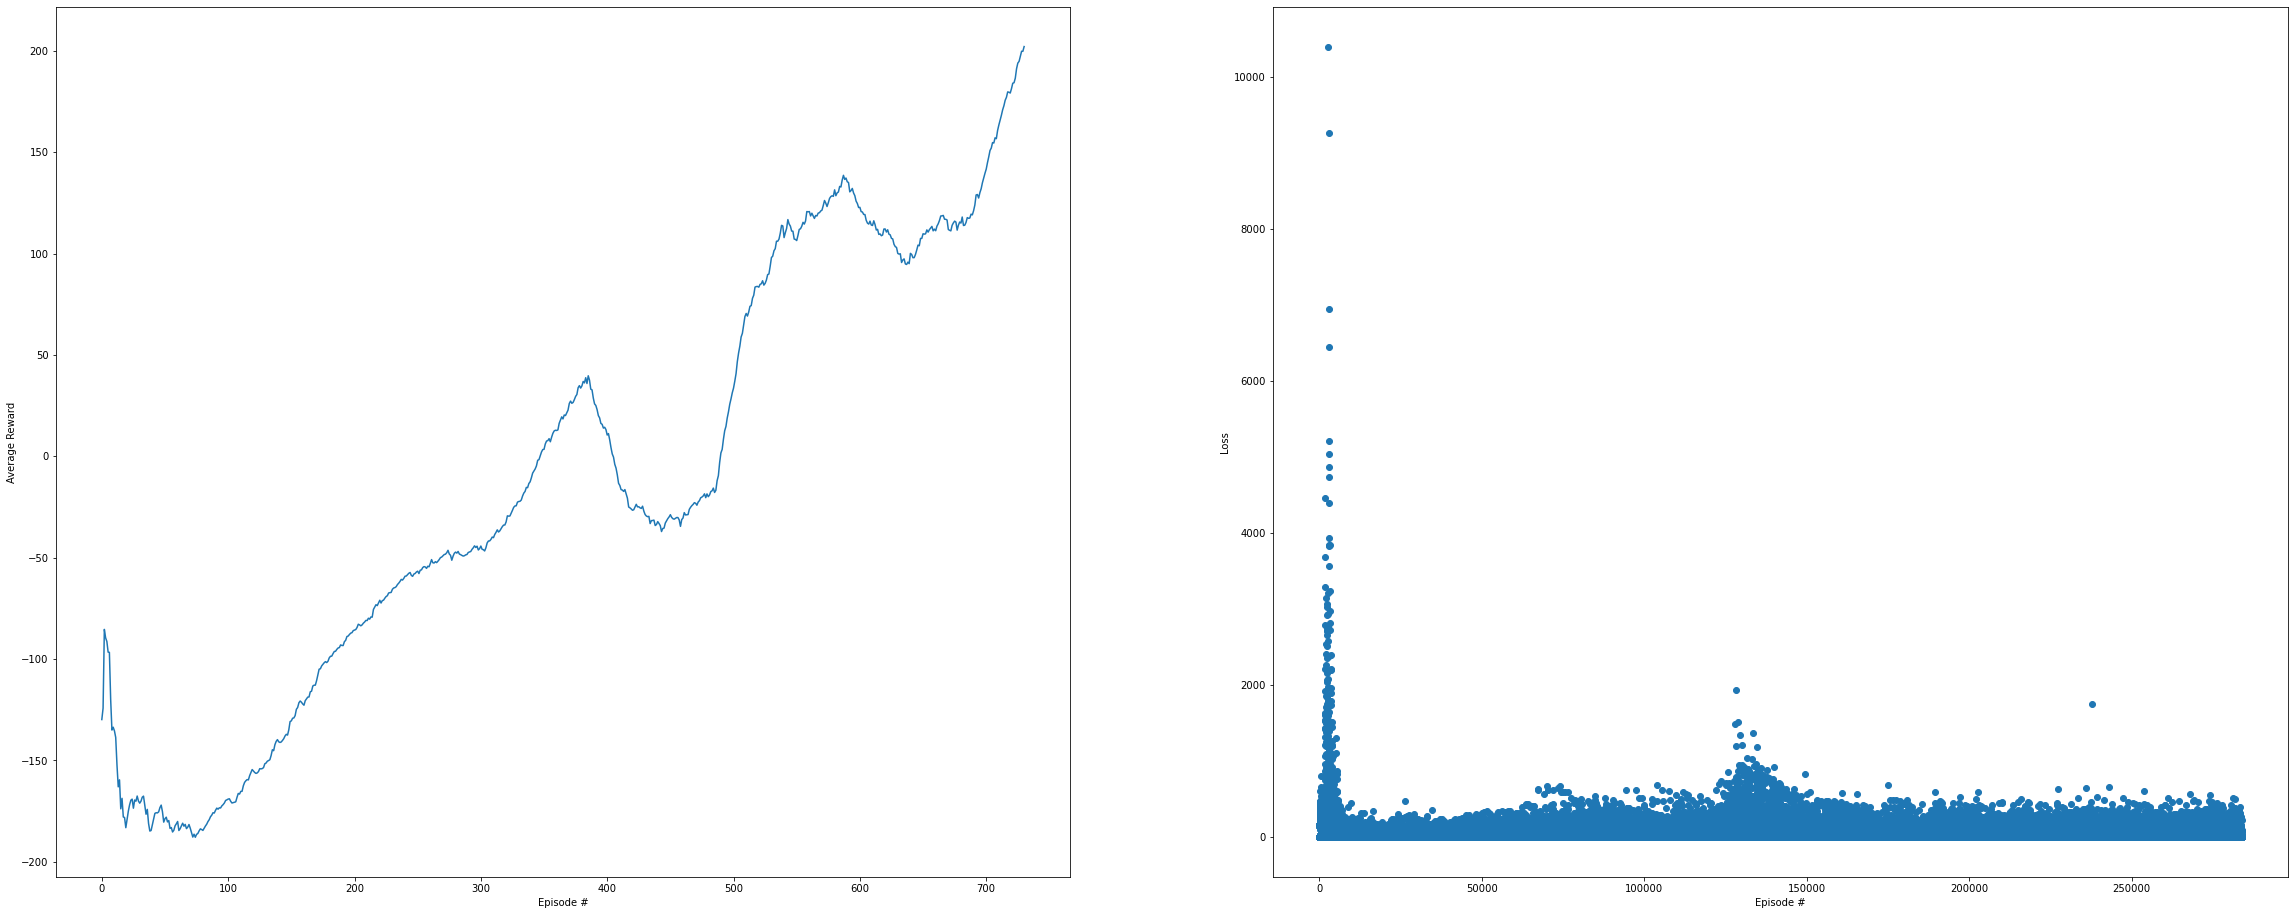

In [4]:
# plot the scores
plt.figure(figsize=(40,16))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(bufMReward)), bufMReward)
plt.ylabel('Average Reward')
plt.xlabel('Episode #')
#plt.show()
# pot the scores
plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(bufLoss)), [b.detach().cpu().numpy() for b in bufLoss])
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()